<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr4/Practice4_neuralode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 170 (delta 74), reused 134 (delta 49), pack-reused 0
Receiving objects: 100% (170/170), 27.60 MiB | 22.41 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=fbe8504056d8955e5b115a077493736296dc54614591cbb697e3c7de34eb1419
  Stored in directory: /tmp/pip-ephem-wheel-cache-21b952vn/wheels/55/59/29/0fb1c63565215773

In [ ]:
from dul_2021.utils.pr4_utils import *

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as accuracy
import IPython
from tqdm.notebook import tqdm
from sklearn.datasets import make_swiss_roll

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook


from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Example 1: Classification


Dataset 1


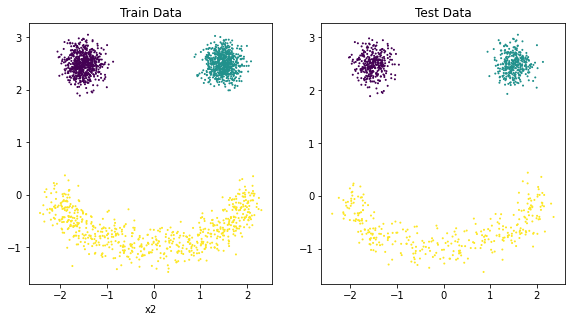

Dataset 2


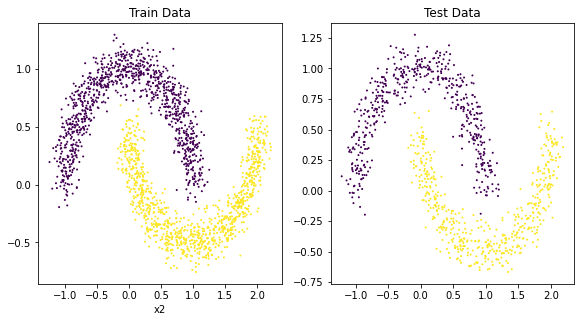

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

In [ ]:
train_data, test_data = get_data(dset_id=2)

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, in_dim=2, d=2, hidden_dim=16, t1=10):
        super().__init__()
        self.in_dim = in_dim
        self.d = d
        self.f = nn.Sequential(nn.Linear(in_dim + 1, hidden_dim),
                               nn.Tanh(), 
                               nn.Linear(hidden_dim, in_dim))
        self.clf = nn.Sequential(nn.Linear(in_dim, d))


        self.t1 = t1
        self.t0 = 0

        self.inter_t = []
        self.inter_z = []
        self.inter_dz_dt = []
        self.collect = False


    # model(t, x)
    def forward(self, t, z):
        

        
        t = t.unsqueeze(0).repeat(z.shape[0], 1) # batch_size x 1
        zt = torch.cat((z, t), dim=1) # batch_size x in_dim + 1

        dz_dt = self.f(zt)

        # for plots
        if self.collect:
            self.inter_t.append(t.detach().cpu().numpy()) 
            self.inter_z.append(z.detach().cpu().numpy()) 
            self.inter_dz_dt.append(dz_dt.detach().cpu().numpy())
        return dz_dt
    
    def free(self):
        self.inter_t = []
        self.inter_z = []
        self.inter_dz_dt = []

    def predict(self, x):
        z = odeint(
                    self,
                    x,
                    torch.FloatTensor([self.t0, self.t1]).to(device),
                    atol=1e-5,
                    rtol=1e-5,
                    method='dopri5',
                )

        z = z[1]
        preds = self.clf(z)
        return preds

    def test(self, dataloader):
        loss = 0
        with torch.no_grad():
            for (x, y) in dataloader:
                x = x.to(device).float()
                preds = self.predict(x)
                loss += F.cross_entropy(preds, y) * x.shape[0]
        return loss / len(dataloader.dataset)

    
    def accuracy(self, dataloader):
        y_pred = np.array([])
        y_true = np.array([])

        with torch.no_grad():
            for (x, y) in dataloader:
                preds = self.predict(x.to(device).float())
                preds = torch.argmax(preds, dim=1)
                y_pred = np.hstack((y_pred, preds.squeeze().cpu().numpy()))
                y_true = np.hstack((y_true, y.squeeze().cpu().numpy()))

        return accuracy(y_pred, y_true)

    def fit(self, train_data, test_data, num_epochs=5,
            lr=1e-3, batch_size=128, plot=True, test=True):
        
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size=batch_size)

        optim = opt.Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = []

        train_acc = []
        test_acc = []


        if test:
            test_losses.append(self.test(test_loader))
            test_acc.append(self.accuracy(test_loader))

        train_acc.append(self.accuracy(train_loader))

        for epoch in tqdm(range(num_epochs)):
            for (x, y) in train_loader:
                x = x.to(device).float()

                preds = self.predict(x)

                loss = F.cross_entropy(preds, y)

                optim.zero_grad()
                loss.backward()
                optim.step()

                train_losses.append(loss.item())
            if test:
                test_losses.append(self.test(test_loader))
                test_acc.append(self.accuracy(test_loader))
            
            train_acc.append(self.accuracy(train_loader))

        if plot:
            plot_train_curves(num_epochs, train_losses, test_losses, title='Training Curve')
            plot_train_curves(num_epochs, train_acc, test_acc, title='Training Curve', y_label='accuracy')
            if test:
                print(f"train accuracy={train_acc[-1]:.4f}\ntest accuracy={test_acc[-1]:.4f}\n")
            else:
                print(f"train accuracy={train_acc[-1]:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

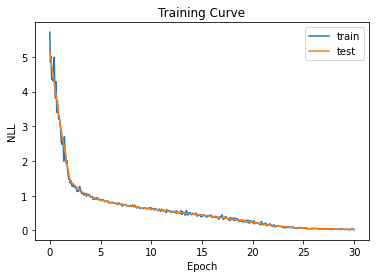

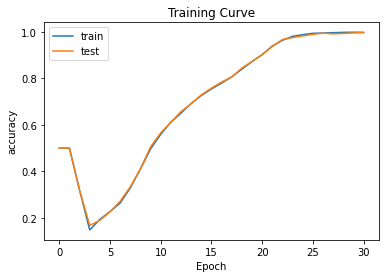

train accuracy=0.9975
test accuracy=0.9960



In [ ]:
model = NeuralODE()
model.fit(train_data, test_data, num_epochs=30)

In [ ]:
def plot_transitions(dataset, ts, model):
    with torch.no_grad():
        x = torch.Tensor(dataset.x)
        y = dataset.y

        zs = odeint(
                        model,
                        x,
                        torch.FloatTensor(ts).to(device),
                        atol=1e-5,
                        rtol=1e-5,
                        method='dopri5',
                    )

        for i, t in enumerate(ts):
            plt.title(f'Data at t={t}')
            plt.scatter(zs[i][:, 0], zs[i][:, 1], s=1, c=y)
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.show()

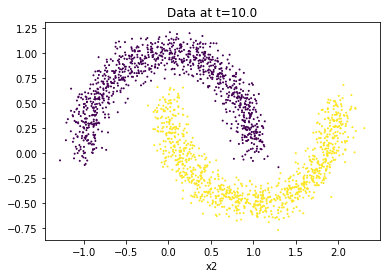

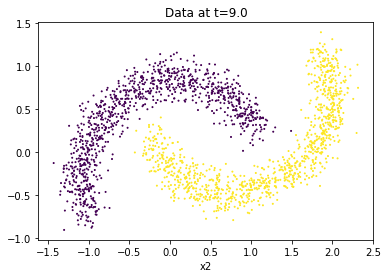

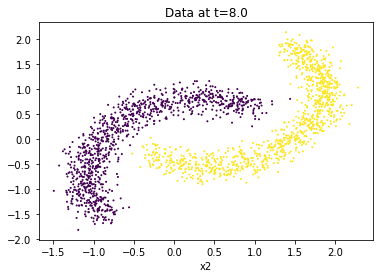

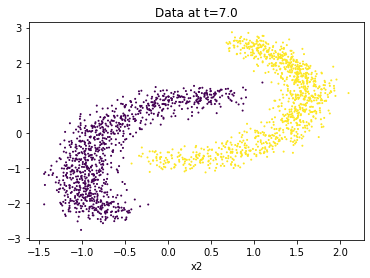

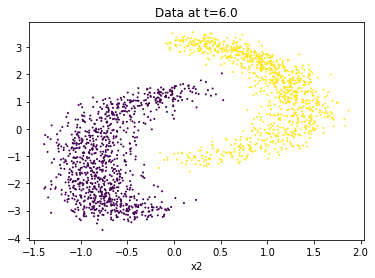

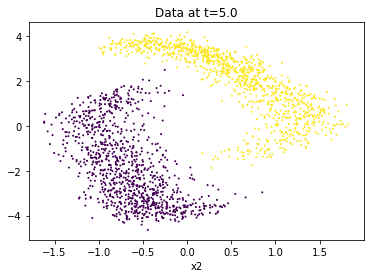

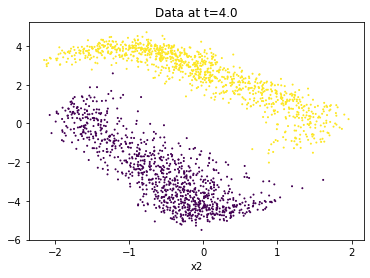

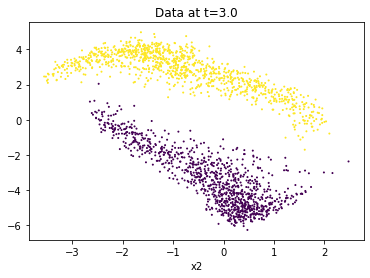

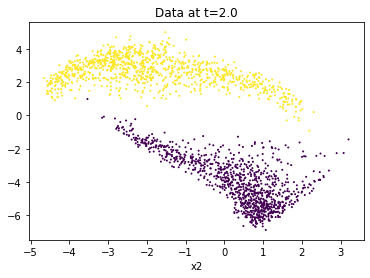

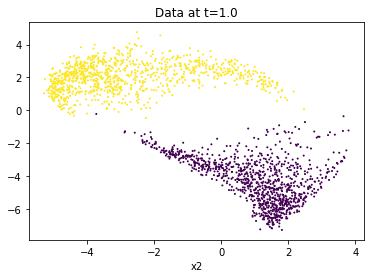

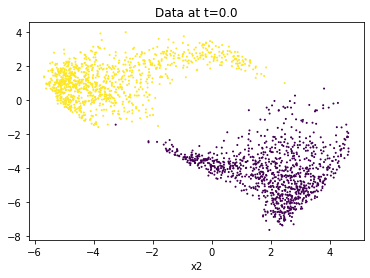

In [ ]:
plot_transitions(train_data, torch.linspace(10, 0, 11), model)

In [ ]:
class SimpleClf(nn.Module):
    def __init__(self, in_dim=2, d=2, hidden_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.d = d
        self.f = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                               nn.Tanh(), 
                               nn.Linear(hidden_dim, in_dim))
        self.clf = nn.Sequential(nn.Tanh(), 
                                 nn.Linear(in_dim, d))

    def predict(self, x):
        z = self.f(x)
        preds = self.clf(z)
        return z

    def test(self, dataloader):
        loss = 0
        with torch.no_grad():
            for (x, y) in dataloader:
                x = x.to(device).float()
                preds = self.predict(x)
                loss += F.cross_entropy(preds, y) * x.shape[0]
        return loss / len(dataloader.dataset)

    
    def accuracy(self, dataloader):
        y_pred = np.array([])
        y_true = np.array([])

        with torch.no_grad():
            for (x, y) in dataloader:
                preds = self.predict(x.to(device).float())
                preds = torch.argmax(preds, dim=1)
                y_pred = np.hstack((y_pred, preds.squeeze().cpu().numpy()))
                y_true = np.hstack((y_true, y.squeeze().cpu().numpy()))

        return accuracy(y_pred, y_true)

    def fit(self, train_data, test_data, num_epochs=100,
            lr=1e-3, batch_size=128, plot=True):
        
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = data.DataLoader(test_data, batch_size=batch_size)

        optim = opt.Adam(self.parameters(), lr=lr)

        train_losses = []
        test_losses = []

        train_acc = []
        test_acc = []


        test_losses.append(self.test(test_loader))
        train_acc.append(self.accuracy(train_loader))
        test_acc.append(self.accuracy(test_loader))


        for epoch in tqdm(range(num_epochs)):
            for (x, y) in train_loader:
                x = x.to(device).float()

                preds = self.predict(x)

                loss = F.cross_entropy(preds, y)

                optim.zero_grad()
                loss.backward()
                optim.step()

                train_losses.append(loss.item())
            test_losses.append(self.test(test_loader))
            train_acc.append(self.accuracy(train_loader))
            test_acc.append(self.accuracy(test_loader))

        if plot:
            plot_train_curves(num_epochs, train_losses, test_losses, title='Training Curve')
            plot_train_curves(num_epochs, train_acc, test_acc, title='accuracy', y_label='accuracy')
            print(f"train accuracy={train_acc[-1]:.4f}\ntest accuracy={test_acc[-1]:.4f}\n")

  0%|          | 0/100 [00:00<?, ?it/s]

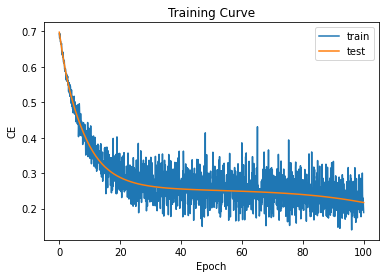

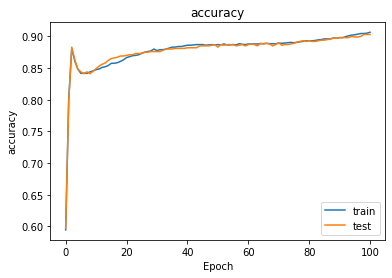

train accuracy=0.9065
test accuracy=0.9030



In [ ]:
model = SimpleClf()
model.fit(train_data, test_data, num_epochs=100)

# Example 2: 1D Evolution

<Figure size 432x288 with 0 Axes>

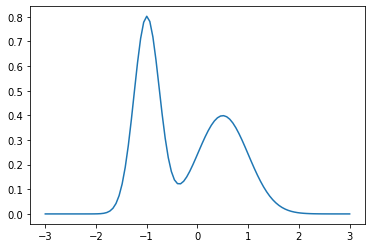

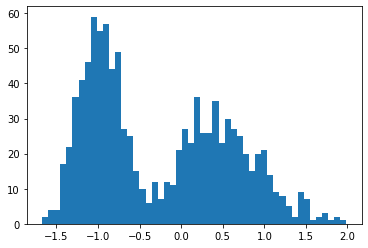

In [ ]:
train_data, test_data = load_demo_1(1000, 100, visualize=True)

In [ ]:
train_data.x = train_data.x.reshape(-1, 1)
test_data.x = test_data.x.reshape(-1, 1)

  0%|          | 0/100 [00:00<?, ?it/s]

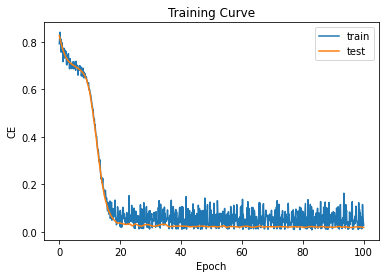

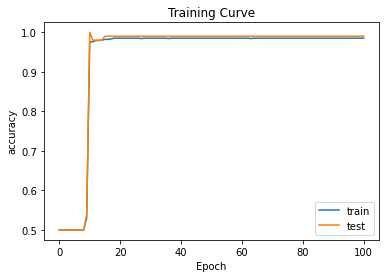

train accuracy=0.9850
test accuracy=0.9900



In [ ]:
model = NeuralODE(in_dim=1, d=2)
model.fit(train_data, test_data,  num_epochs=100, lr=1e-3)

In [ ]:
n = 5
ts = torch.FloatTensor([0, 4])
ind = np.random.choice(np.arange(len(test_data)), n)
x = torch.Tensor(test_data.x[ind])
y = test_data.y[ind]

In [ ]:
x.squeeze(), y

(tensor([ 0.6264,  0.5289, -1.1504,  0.6900, -0.7298]), array([0, 0, 1, 0, 1]))

In [ ]:
model.collect = True

In [ ]:
t = []
z = []

In [ ]:
for i in range(n):
    _ = odeint(
                model,
                x[i].unsqueeze(0),
                torch.FloatTensor(ts).to(device),
                atol=1e-5,
                rtol=1e-5,
                method='dopri5',
            )
    t.append(np.hstack(model.inter_t).squeeze())
    z.append(np.hstack(model.inter_z).squeeze())
    model.free()

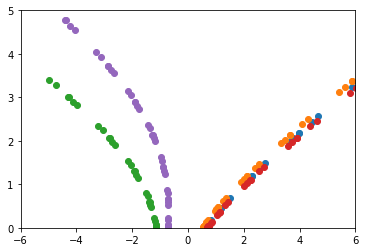

In [ ]:
for i in range(n):
    plt.scatter(z[i], t[i])
    plt.ylim(0, 5)
    plt.xlim(-6, 6)
    # plt.gca().invert_yaxis()

# Example 3: Autograd

In [ ]:
x = nn.Parameter(torch.Tensor([2.0, 3.0]), requires_grad=True)
y = nn.Parameter(torch.Tensor([-1.0, -2.0]), requires_grad=True)

$$z = 3xy + y^2$$

In [ ]:
z = 3 * x * y + y * y

$$\frac{\partial z_0}{\partial x_0} = 3 y_0 = -3$$
$$\frac{\partial z_0}{\partial y_0} = 3 x_0 + 2 y_0 = 6 - 2 = 4$$
$$\frac{\partial z_0}{\partial y_1} = 0$$
$$\frac{\partial z_0}{\partial x_1} = 0$$


In [ ]:
torch.autograd.grad(z[0], [x, y], create_graph=True)

(tensor([-3., -0.], grad_fn=<MulBackward0>),
 tensor([4., 0.], grad_fn=<AddBackward0>))

In [ ]:
torch.autograd.grad(z, x)

RuntimeError: ignored